# Negative binomial modeling of simulated CRISPR screen data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import Any, Union

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from scipy import stats
from theano import tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io
from src.loggers import logger
from src.modeling import pymc3_sampling_api as pmapi
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_classic()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1042
np.random.seed(RANDOM_SEED)

sources of simulated NB data:

- [PyMC3 docs: "GLM: Negative Binomial Regression"](https://docs.pymc.io/pymc-examples/examples/generalized_linear_models/GLM-negative-binomial-regression.html)

In [5]:
def get_nb_vals(
    mu: float, alpha: float, size: Union[int, tuple[int, ...]]
) -> np.ndarray:
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)

## Simulation 1. Single sgRNA

In [6]:
n = 100  # number simulated data points

# Simulation parameters.
sim1: dict[str, Any] = {"β": -0.5, "α": 2.0}

# Simulated data.
sim1_data = pd.DataFrame({"initial_read_count": np.random.poisson(100, n)})
sim1_data["initial_read_count_log"] = np.log(sim1_data)
eta = sim1["β"]

mu = np.exp(eta) * sim1_data["initial_read_count"]
sim1_data["final_read_count"] = [
    get_nb_vals(mu[i], sim1["α"], size=1) for i in range(n)
]

sim1_data.head()

,initial_read_count,initial_read_count_log,final_read_count
0,95,4.553877,15
1,110,4.700480,128
2,122,4.804021,37
3,88,4.477337,34
4,124,4.820282,33


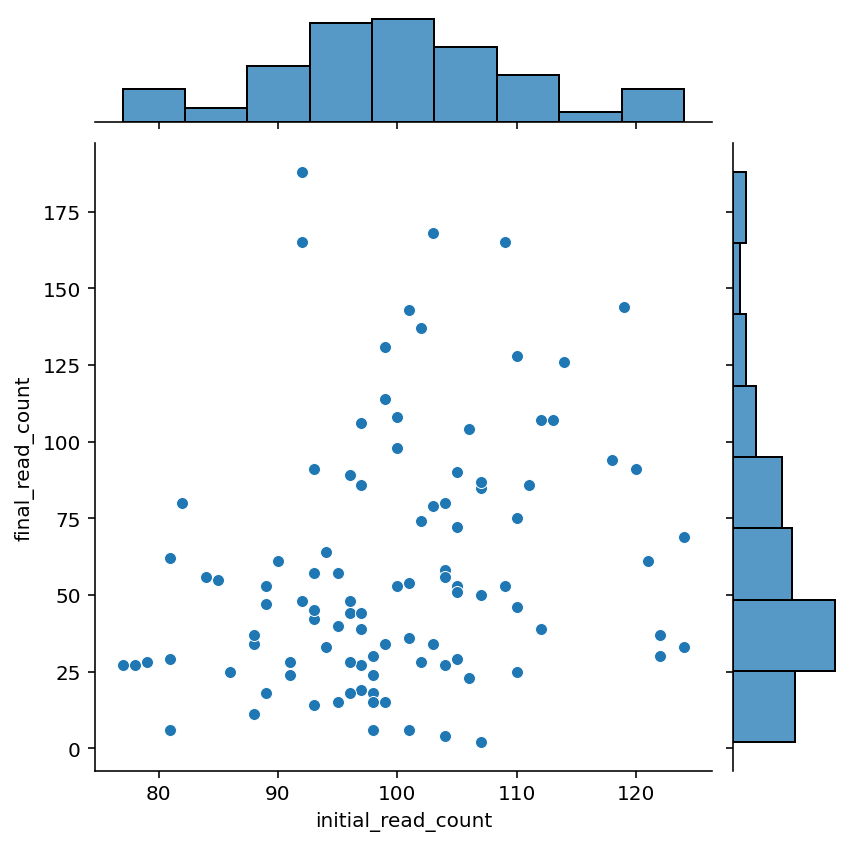

In [7]:
sns.jointplot(data=sim1_data, x="initial_read_count", y="final_read_count");

Simulation 1 model `sim1_model`:

$$
\begin{gather}
\beta \sim N(0, 2) \\
\eta = \beta
\end{gather}
$$

Simulation 1 model `sim1_model`:

$$
\begin{aligned}
\beta &\sim N(0, 2) \\
\eta &= \beta \\
\mu &= \exp(\eta) \times \text{initial read counts} \\
\alpha &\sim \text{HalfNormal}(0, 5) \\
y &\sim \text{NB}(\mu, \alpha)
\end{aligned}
$$

In [8]:
with pm.Model() as sim1_model:
    β = pm.Normal("β", 0, 2)
    η = pm.Deterministic("η", β)
    μ = pm.Deterministic("μ", pm.math.exp(η) * sim1_data.initial_read_count.values)
    α = pm.HalfNormal("α", 5)
    y = pm.NegativeBinomial("y", μ, α, observed=sim1_data.final_read_count.values)

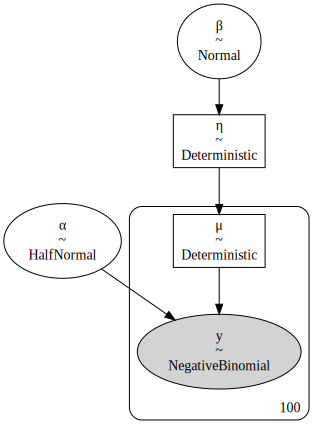

In [9]:
pm.model_to_graphviz(sim1_model)

In [10]:
with sim1_model:
    sim1_trace = pm.sample(
        tune=2000, random_seed=850, chains=4, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.


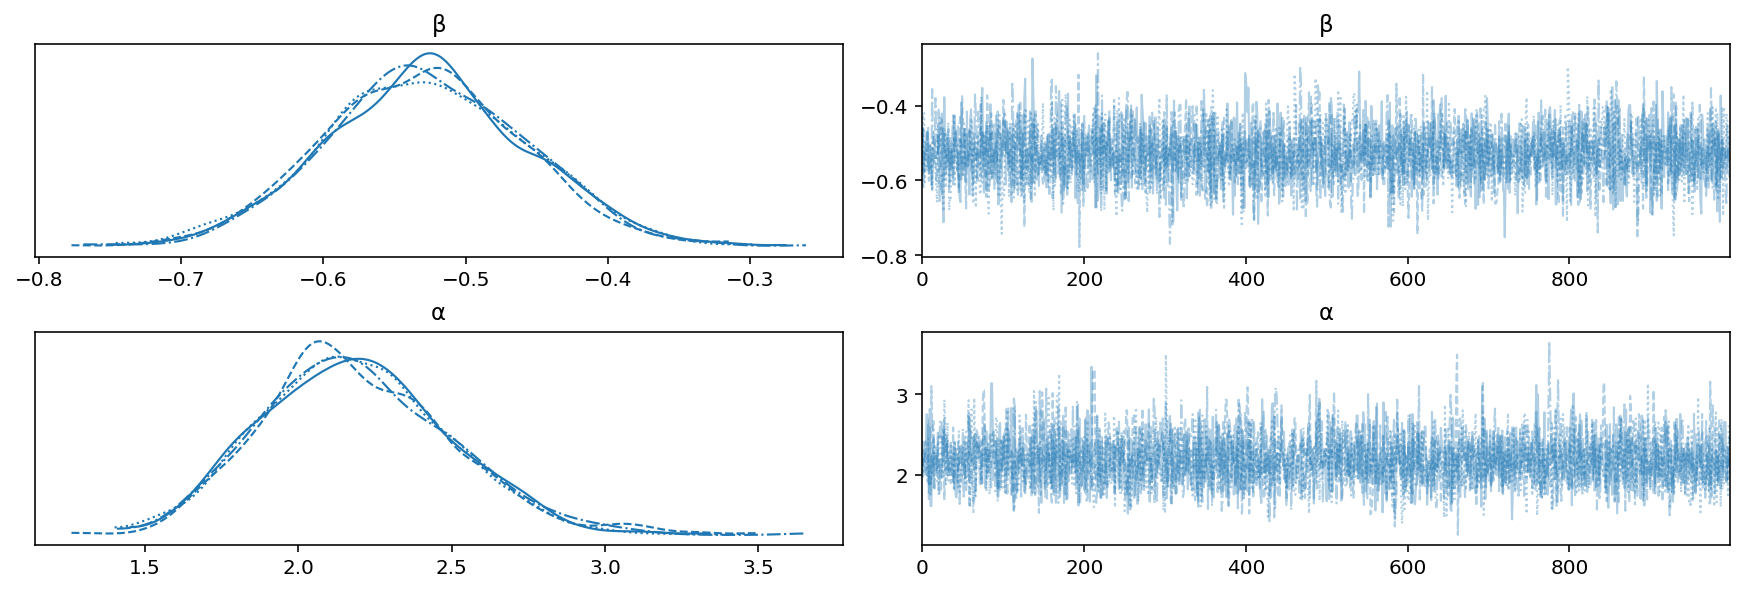

In [11]:
az.plot_trace(sim1_trace, var_names=["β", "α"]);

In [12]:
az.summary(sim1_trace, var_names=["α", "β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.188,0.304,1.649,2.752,0.005,0.004,3624.0,2695.0,1.0
β,-0.528,0.071,-0.659,-0.396,0.001,0.001,3613.0,2904.0,1.0


### Scaling the initial number of reads instead of including as exposure.

Simulation 1 model `sim2_model`:

$$
\begin{aligned}
\beta &\sim N(0, 2) \\
\eta &= \beta + \beta_s \frac{X_\text{initial reads}}{100} \\
\mu &= \exp(\eta) \\
\alpha &\sim \text{HalfNormal}(0, 5) \\
y &\sim \text{NB}(\mu, \alpha)
\end{aligned}
$$

In [13]:
with pm.Model() as sim1_model_rescale:
    β = pm.Normal("β", 0, 2)
    β_s = pm.Normal("β_s", 0, 2)
    η = pm.Deterministic("η", β + β_s * (sim1_data.initial_read_count / 100))
    μ = pm.Deterministic("μ", pm.math.exp(η))
    α = pm.HalfNormal("α", 5)
    y = pm.NegativeBinomial("y", μ, α, observed=sim1_data.final_read_count.values)

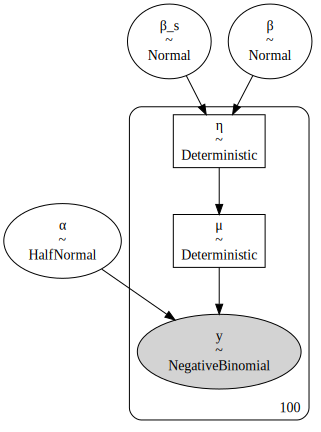

In [14]:
pm.model_to_graphviz(sim1_model_rescale)

In [15]:
with sim1_model_rescale:
    sim1_rescale_trace = pm.sample(
        tune=2000, chains=4, random_seed=823, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β_s, β]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8884322278721798, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


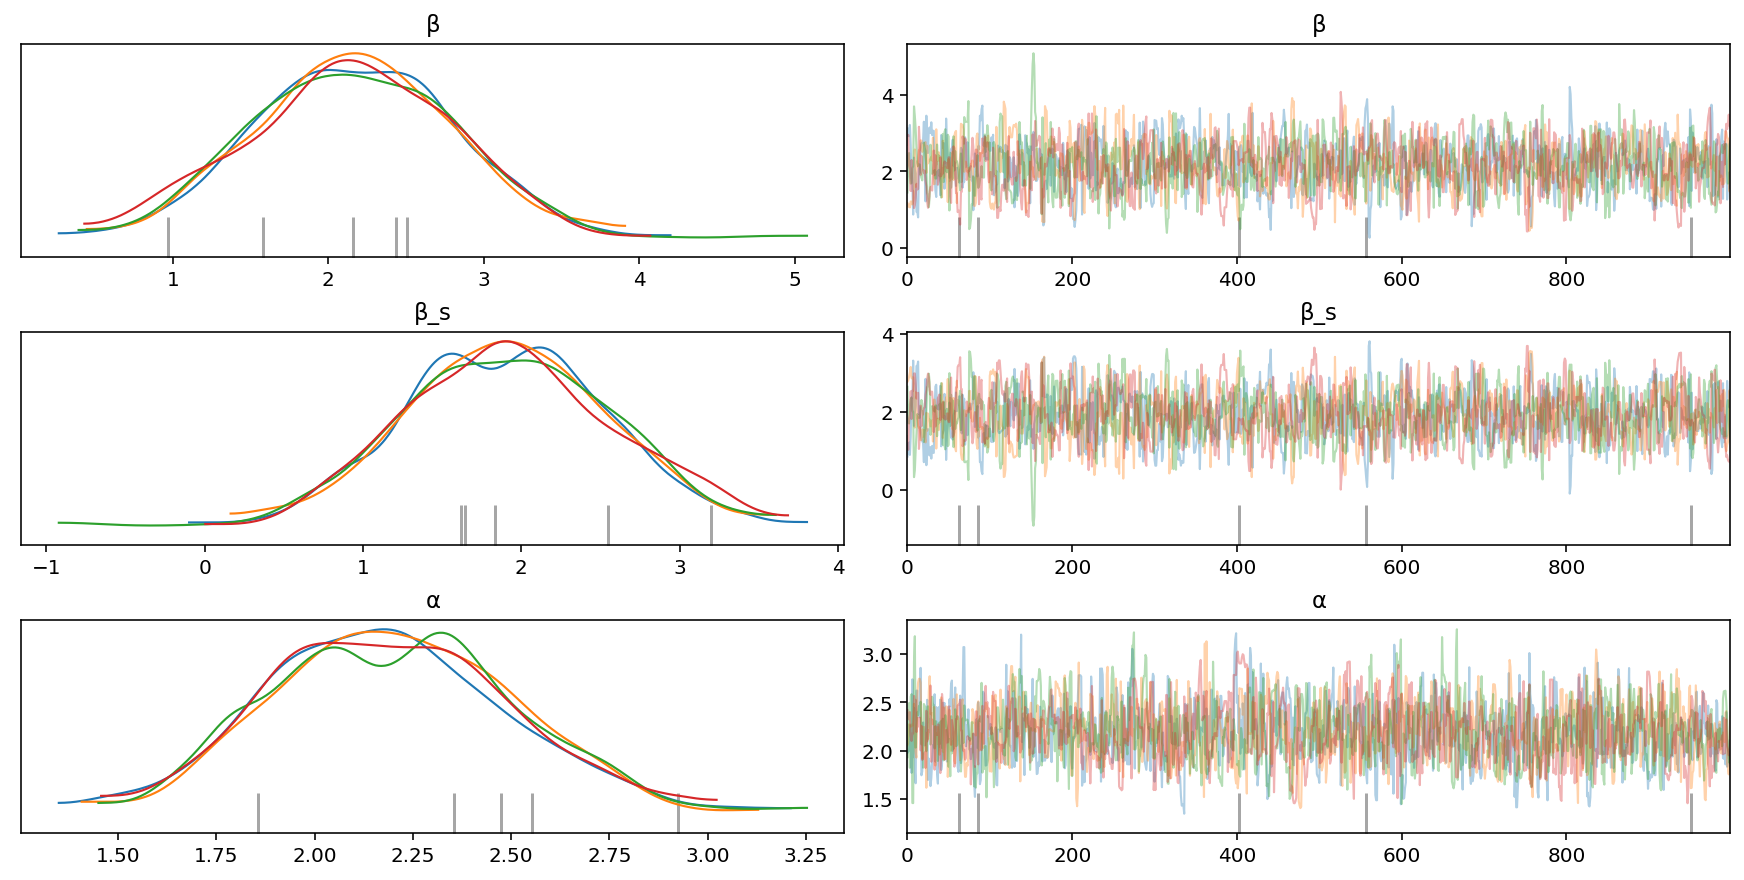

In [16]:
az.plot_trace(
    sim1_rescale_trace, var_names=["β", "α"], filter_vars="like", compact=False
);

In [17]:
az.summary(sim1_rescale_trace, var_names=["α", "β"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,2.157,0.638,1.002,3.343,0.018,0.013,1254.0,1467.0,1.0
β_s,1.910,0.638,0.702,3.058,0.018,0.013,1248.0,1458.0,1.0
α,2.194,0.306,1.655,2.771,0.008,0.006,1402.0,1256.0,1.0


The issue is definitely colinearity between \[beta\] and $\beta_s$.
In this case, since the real value for $\beta_s = 1$, this model is equivalent to `sim1_model` where the initial read count is included as an exposure.

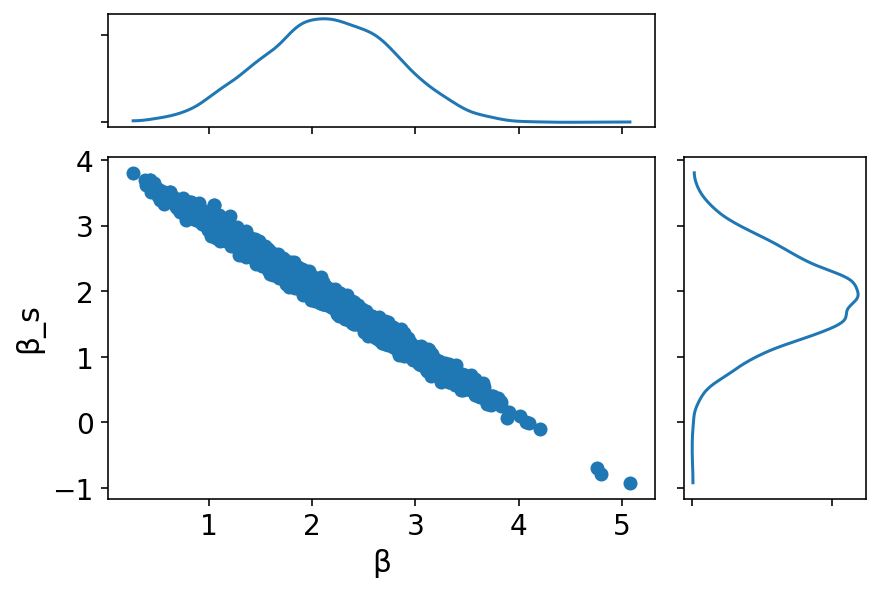

In [18]:
az.plot_joint(sim1_rescale_trace, var_names=["β", "β_s"]);

## Simulation 2. Multiple sgRNA

In [19]:
n_per_guide = 10  # number simulated data points
n_guides = 10
n = n_per_guide * n_guides

guides = [f"sgrna_{i:02d}" for i in range(n_guides)]

# Simulation parameters.
sim2: dict[str, Any] = {"μ_β": -1.0, "σ_β": 1.0, "α": 2.0}
sim2["β"] = np.random.normal(sim2["μ_β"], sim2["σ_β"], size=n_guides)

# Simulated data.
sim2_data = pd.DataFrame(
    {
        "initial_read_count": np.random.poisson(100, n_per_guide * n_guides),
        "sgrna": np.repeat(guides, n_per_guide),
    }
)
sim2_data["sgrna"] = pd.Categorical(sim2_data["sgrna"], categories=guides, ordered=True)
eta = [sim2["β"][i] for i in sim2_data.sgrna.factorize(sort=True)[0]]

mu = np.exp(eta) * sim2_data["initial_read_count"]
sim2_data["final_read_count"] = [
    get_nb_vals(mu[i], sim2["α"], size=1) for i in range(n)
]

sim2_data.head()

,initial_read_count,sgrna,final_read_count
0,90,sgrna_00,18
1,87,sgrna_00,90
2,78,sgrna_00,105
3,93,sgrna_00,8
4,110,sgrna_00,112


In [20]:
sim2["β"]

array([-0.57756479,  0.2996549 , -0.06942154, -0.74148995, -1.34695387,
       -0.30449958, -0.05467121, -1.43114412, -2.19361327, -0.76110797])

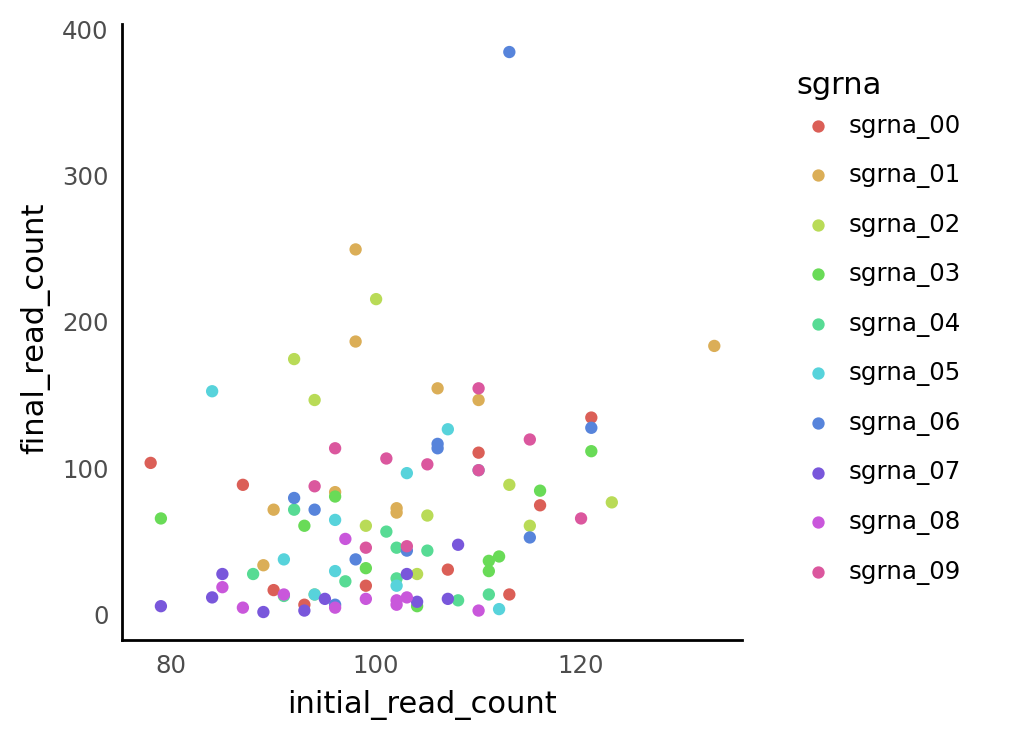

<ggplot: (8772319839570)>

In [21]:
(
    gg.ggplot(sim2_data, gg.aes(x="initial_read_count", y="final_read_count"))
    + gg.geom_point(gg.aes(color="sgrna"))
    + gg.scale_color_hue()
)

Simulation 2 model `sim2_model`:

$$
\begin{aligned}
\mu_\beta &\sim N(0, 2) \\
\sigma_\beta &\sim \text{HalfNormal}(2) \\
\beta_g &\sim_g N(\mu_\beta, \sigma_\beta) \\
\eta &= \beta_g[\text{sgRNA}] \\
\mu &= \exp(\eta) \times \text{initial read counts} \\
\alpha &\sim \text{HalfNormal}(0, 5) \\
y &\sim \text{NB}(\mu, \alpha)
\end{aligned}
$$

In [22]:
sgrna_idx = sim2_data.sgrna.factorize(sort=True)[0]

with pm.Model() as sim2_model:
    μ_β = pm.Normal("μ_β", 0, 2)
    σ_β = pm.HalfNormal("σ_β", 2)
    β = pm.Normal("β", μ_β, σ_β, shape=n_guides)
    η = pm.Deterministic("η", β[sgrna_idx])
    μ = pm.Deterministic("μ", pm.math.exp(η) * sim2_data.initial_read_count.values)
    α = pm.HalfNormal("α", 5)
    y = pm.NegativeBinomial("y", μ, α, observed=sim2_data.final_read_count.values)

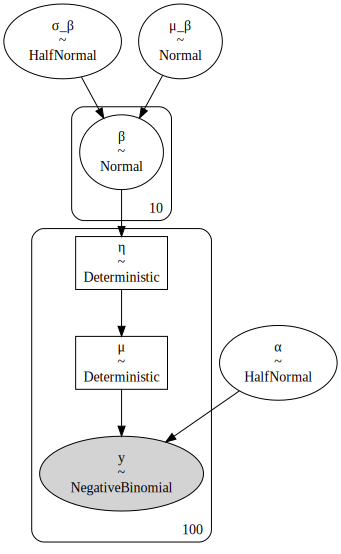

In [23]:
pm.model_to_graphviz(sim2_model)

In [24]:
with sim2_model:
    sim2_trace = pm.sample(
        tune=2000, random_seed=851, chains=4, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ_β, μ_β]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


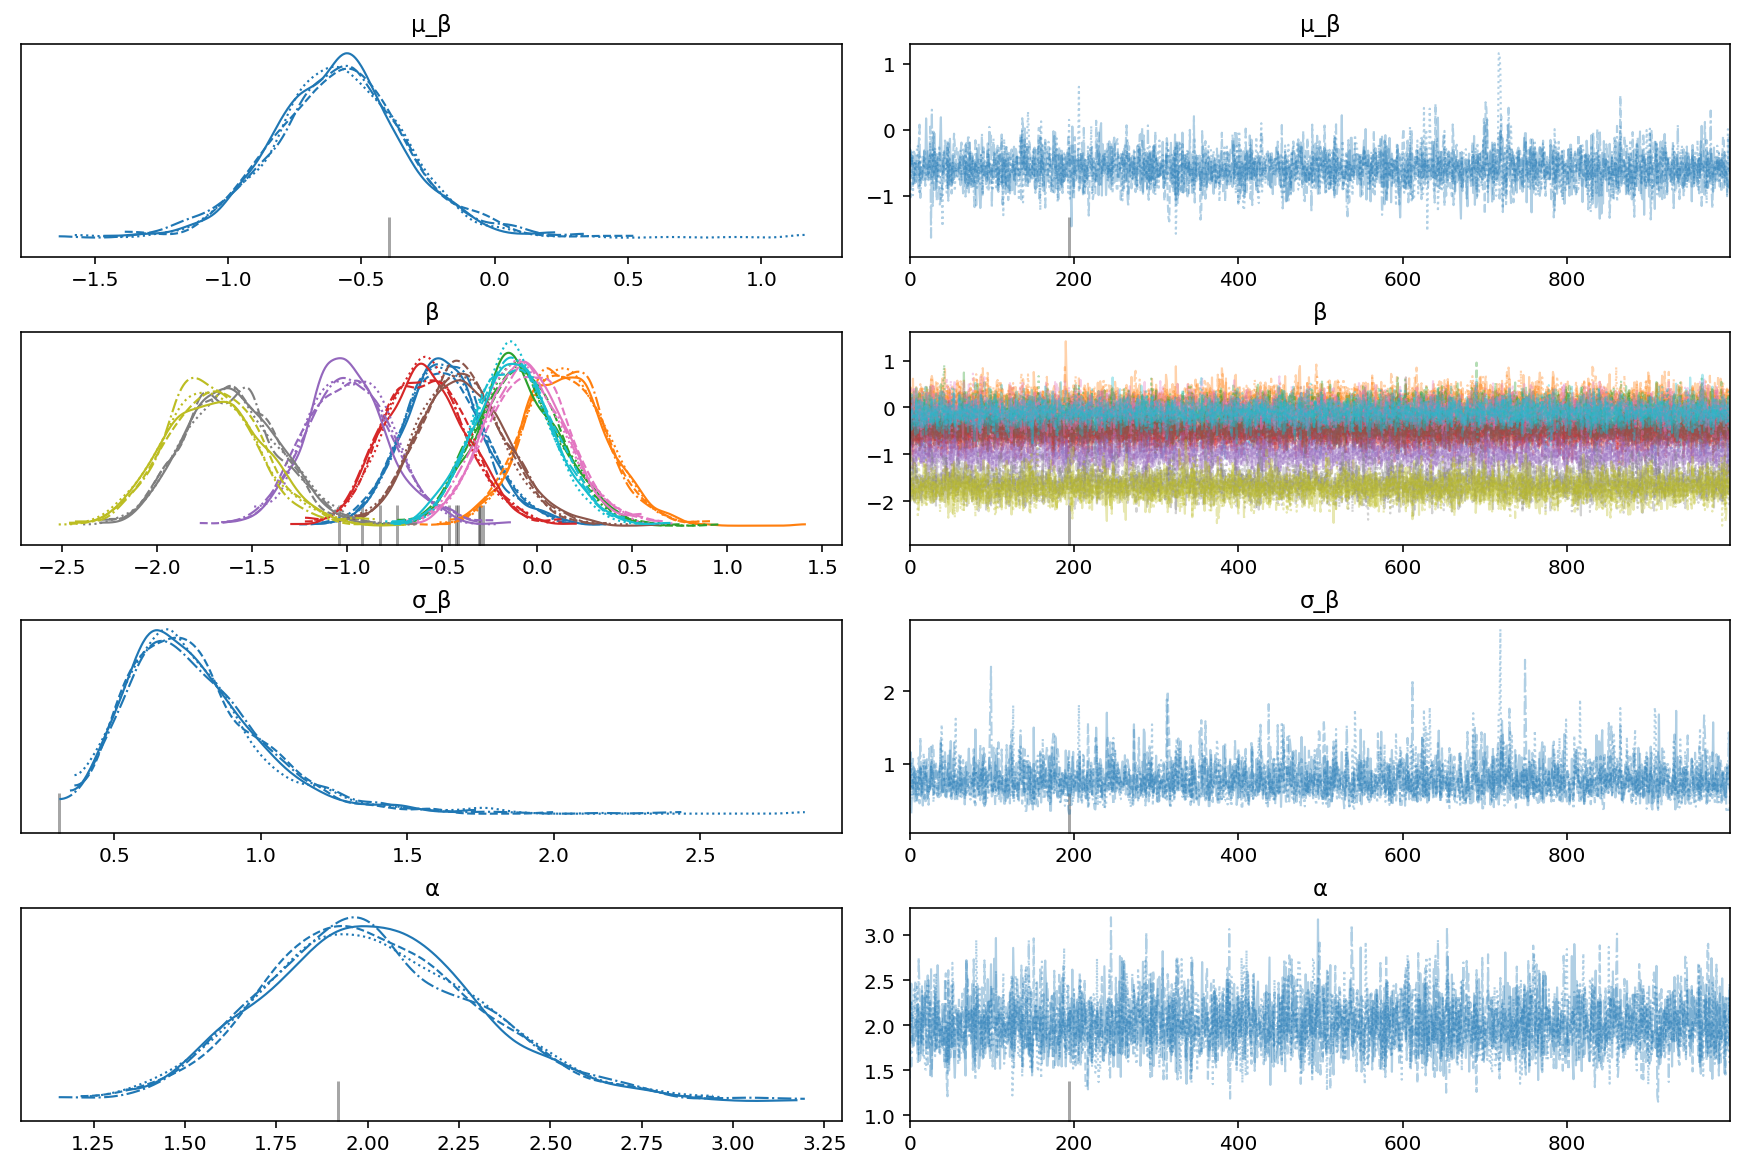

In [25]:
az.plot_trace(sim2_trace, var_names=["β", "α"], filter_vars="like");

In [26]:
az.summary(sim2_trace, var_names=["α", "β"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_β,-0.581,0.256,-1.070,-0.117,0.004,0.003,4283.0,2933.0,1.0
β[0],-0.489,0.214,-0.906,-0.088,0.003,0.002,5206.0,2711.0,1.0
β[1],0.146,0.217,-0.260,0.554,0.003,0.003,4547.0,2567.0,1.0
β[2],-0.101,0.221,-0.502,0.313,0.003,0.003,5402.0,3004.0,1.0
β[3],-0.586,0.217,-0.989,-0.184,0.003,0.002,4762.0,2785.0,1.0
β[4],-0.988,0.223,-1.437,-0.600,0.003,0.002,5064.0,2636.0,1.0
β[5],-0.396,0.223,-0.801,0.031,0.003,0.002,5099.0,2351.0,1.0
β[6],-0.059,0.215,-0.464,0.348,0.003,0.003,4622.0,2708.0,1.0
β[7],-1.606,0.249,-2.070,-1.161,0.004,0.003,4628.0,2511.0,1.0
β[8],-1.708,0.250,-2.174,-1.241,0.004,0.003,4349.0,2620.0,1.0


---

In [27]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.48 minutes


In [28]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-10-05

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-236.o2.rc.hms.harvard.edu

Git branch: nb-model-2

plotnine  : 0.8.0
numpy     : 1.21.2
seaborn   : 0.11.2
theano    : 1.0.5
pandas    : 1.3.2
pymc3     : 3.11.2
scipy     : 1.7.1
matplotlib: 3.4.3
arviz     : 0.11.2
re        : 2.2.1

